# Deteksi Lubang Jalan dengan YOLO dan Preprocessing PCD

Pipeline lengkap untuk deteksi lubang jalan menggunakan YOLOv8 dengan penerapan 4 konsep preprocessing Pengolahan Citra Digital:

1. **Image Resizing**: Normalisasi ukuran gambar dengan mempertahankan aspect ratio
2. **CLAHE Enhancement**: Peningkatan kontras adaptif untuk memperjelas detail
3. **Bilateral Filter**: Pengurangan noise dengan mempertahankan tepi objek
4. **Data Augmentation**: Ekspansi dataset dengan transformasi geometrik dan fotometrik

Pipeline ini dirancang untuk meningkatkan kualitas dataset sebelum proses training YOLO, sehingga menghasilkan model dengan akurasi deteksi yang lebih tinggi.

## 1. Setup dan Instalasi Library

Bagian ini menginstal dan mengimport semua library yang dibutuhkan untuk preprocessing dan training YOLO.

In [1]:
# Instalasi library yang dibutuhkan
# Uncomment baris di bawah jika belum terinstall

# !pip install ultralytics opencv-python albumentations matplotlib pillow pyyaml tqdm numpy scikit-learn

In [2]:
# Import library untuk pengolahan citra dan machine learning
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import shutil
import yaml
import random
from pathlib import Path
from tqdm import tqdm
import albumentations as A
from ultralytics import YOLO
import warnings

# Menonaktifkan warning untuk output yang lebih bersih
warnings.filterwarnings('ignore')

# Konfigurasi matplotlib untuk visualisasi
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

## 2. Konfigurasi Path Dataset

Mendefinisikan path untuk dataset original, dataset hasil preprocessing, dan output training.

In [3]:
ORIGINAL_DATASET = "dataset"
# Path untuk menyimpan dataset hasil preprocessing
PREPROCESSED_DATASET = "pothole_preprocessed"
# Path untuk menyimpan dataset hasil augmentasi
AUGMENTED_DATASET = "pothole_augmented"
# Path untuk menyimpan hasil training
OUTPUT_DIR = "yolo_training_results"

# Membuat direktori jika belum ada
os.makedirs(PREPROCESSED_DATASET, exist_ok=True)
os.makedirs(AUGMENTED_DATASET, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Inspeksi Dataset Original

Memeriksa struktur dan isi dataset original sebelum preprocessing.

In [4]:
# Fungsi untuk menghitung jumlah file dalam dataset
def count_dataset_files(dataset_path):
    stats = {}
    for split in ['train', 'valid', 'test']:
        images_path = os.path.join(dataset_path, split, 'images')
        labels_path = os.path.join(dataset_path, split, 'labels')
        
        if os.path.exists(images_path):
            images = glob.glob(os.path.join(images_path, '*.*'))
            labels = glob.glob(os.path.join(labels_path, '*.txt'))
            stats[split] = {
                'images': len(images),
                'labels': len(labels)
            }
    return stats

# Hitung statistik dataset original
original_stats = count_dataset_files(ORIGINAL_DATASET)

print("Statistik Dataset Original:")
print("-" * 50)
for split, counts in original_stats.items():
    print(f"{split.capitalize()}:")
    print(f"  Jumlah gambar: {counts['images']}")
    print(f"  Jumlah label: {counts['labels']}")
    print()

Statistik Dataset Original:
--------------------------------------------------
Train:
  Jumlah gambar: 465
  Jumlah label: 465

Valid:
  Jumlah gambar: 133
  Jumlah label: 133

Test:
  Jumlah gambar: 67
  Jumlah label: 67



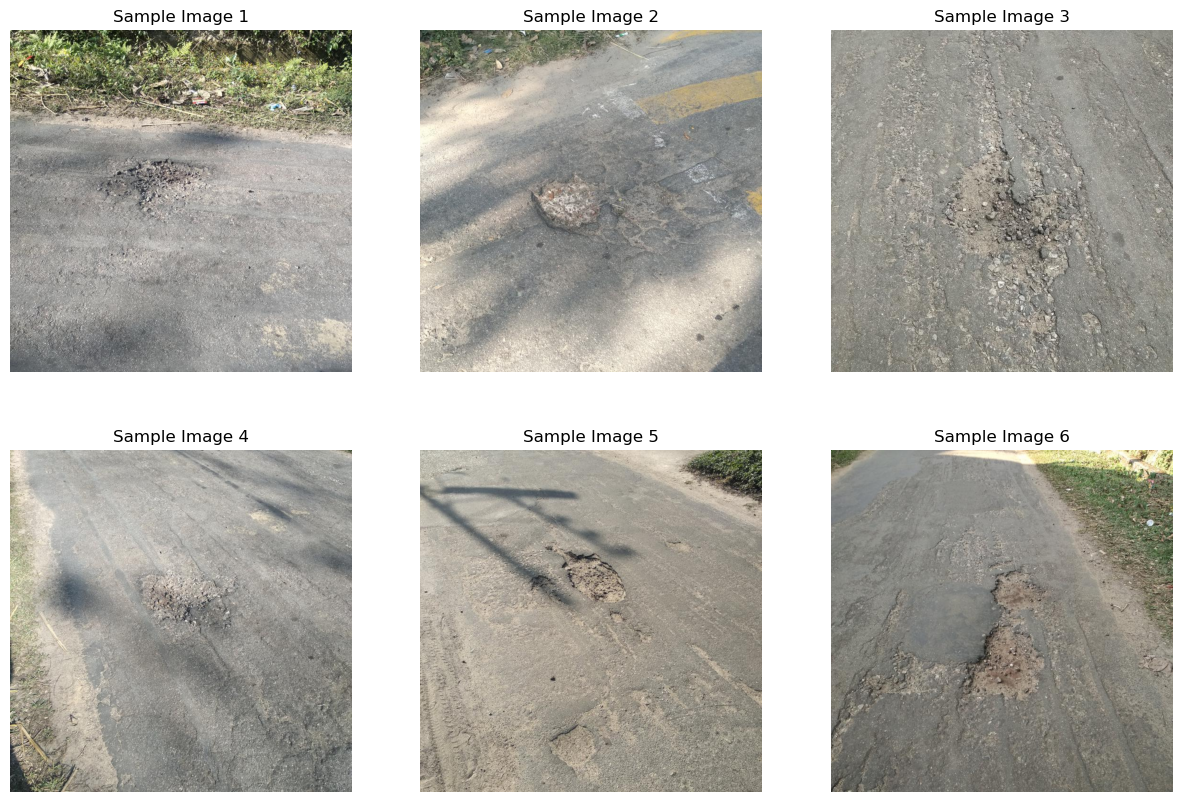

In [6]:
# Ambil beberapa sampel gambar dari train set
train_images = glob.glob(os.path.join(ORIGINAL_DATASET, 'train', 'images', '*.*'))[:6]

# Visualisasi
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, img_path in enumerate(train_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(f'Sample Image {i+1}')
    axes[i].axis('off')
plt.savefig(os.path.join(OUTPUT_DIR, 'original_samples.png'), dpi=100, bbox_inches='tight')
plt.show()

## 5. Operasi Image Resizing 

Resize gambar ke ukuran standar (640x640) dengan mempertahankan aspect ratio menggunakan padding. Hal ini penting untuk:
- Konsistensi input untuk model YOLO
- Menghindari distorsi gambar
- Mempercepat proses training

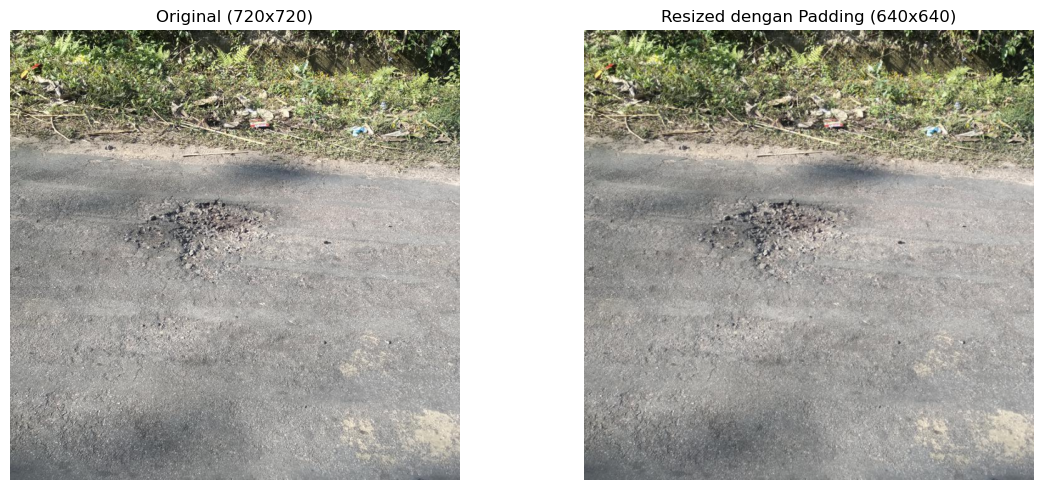

Ukuran original: (720, 720, 3)
Ukuran setelah resize: (640, 640, 3)


In [ ]:
def resize(image, target_size=640):
    h, w = image.shape[:2]
    
    # Hitung skala resize agar fit ke target size
    scale = min(target_size / h, target_size / w)
    new_h = int(h * scale)
    new_w = int(w * scale)
    
    # Resize gambar dengan interpolasi linear
    resized = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    
    # Buat canvas kosong dengan target size
    padded = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    
    # Hitung offset untuk center gambar
    y_offset = (target_size - new_h) // 2
    x_offset = (target_size - new_w) // 2
    
    # Place gambar di center canvas
    padded[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized
    
    return padded, scale, (x_offset, y_offset)

# Test fungsi resize pada sampel gambar
test_img_path = train_images[0]
test_img = cv2.imread(test_img_path)
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

resized_img, scale, offsets = resize(test_img, target_size=640)
resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(test_img_rgb)
axes[0].set_title(f"Original ({test_img.shape[1]}x{test_img.shape[0]})")
axes[0].axis('off')

axes[1].imshow(resized_img_rgb)
axes[1].set_title(f"Resized dengan Padding (640x640)")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'preprocessing_1_resize.png'), dpi=100, bbox_inches='tight')
plt.show()

print(f"Ukuran original: {test_img.shape}")
print(f"Ukuran setelah resize: {resized_img.shape}")

## 6. Konsep PCD 2: CLAHE Enhancement

CLAHE (Contrast Limited Adaptive Histogram Equalization) meningkatkan kontras lokal pada gambar. Berbeda dengan histogram equalization biasa, CLAHE:
- Bekerja pada tile-tile kecil (adaptive)
- Membatasi amplifikasi kontras untuk menghindari noise
- Sangat efektif untuk gambar dengan pencahayaan tidak merata

Pada aplikasi deteksi lubang jalan, CLAHE membantu memperjelas detail lubang yang mungkin gelap atau tersembunyi.

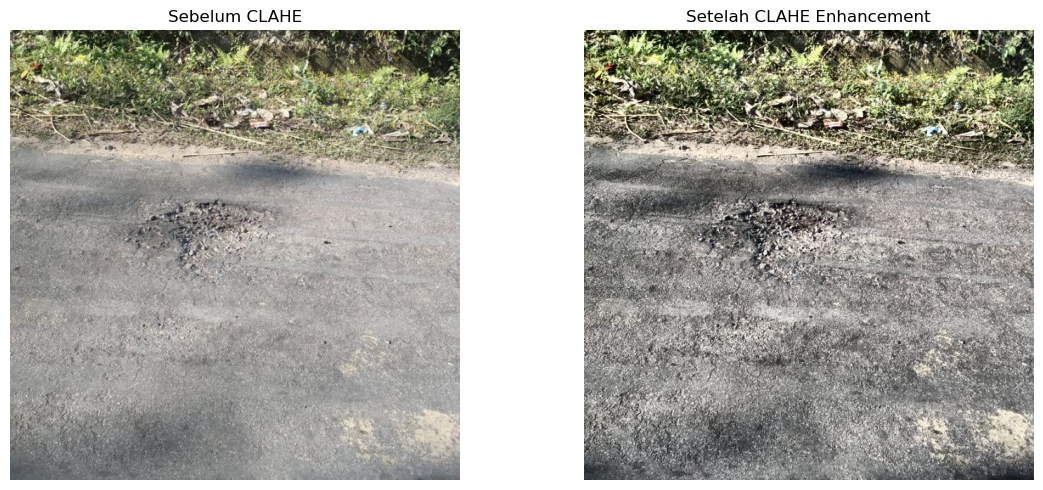

In [ ]:
def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Menerapkan CLAHE untuk meningkatkan kontras lokal.
    CLAHE diterapkan pada channel L di LAB color space untuk 
    mempertahankan informasi warna.
    
    Args:
        image: Input image BGR
        clip_limit: Batas clipping untuk mencegah over-amplification
        tile_grid_size: Ukuran grid untuk adaptive processing
    
    Returns:
        enhanced_image: Gambar dengan kontras yang ditingkatkan
    """
    # Konversi ke LAB color space
    # L: Lightness, A: Green-Red, B: Blue-Yellow
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    # Buat CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    
    # Apply CLAHE hanya pada L channel
    l_clahe = clahe.apply(l)
    
    # Merge kembali channels
    lab_clahe = cv2.merge([l_clahe, a, b])
    
    # Konversi kembali ke BGR
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    
    return enhanced

# Test CLAHE pada gambar hasil resize
clahe_img = apply_clahe(resized_img)
clahe_img_rgb = cv2.cvtColor(clahe_img, cv2.COLOR_BGR2RGB)

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(resized_img_rgb)
axes[0].set_title("Sebelum CLAHE")
axes[0].axis('off')

axes[1].imshow(clahe_img_rgb)
axes[1].set_title("Setelah CLAHE Enhancement")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'preprocessing_2_clahe.png'), dpi=100, bbox_inches='tight')
plt.show()

## 7. Konsep PCD 3: Bilateral Filter

Bilateral Filter adalah filter non-linear yang mengurangi noise sambil mempertahankan tepi objek. Berbeda dengan Gaussian blur yang mengaburkan seluruh gambar, bilateral filter:
- Mempertimbangkan jarak spasial dan perbedaan intensitas
- Mengaburkan area smooth (flat region)
- Mempertahankan ketajaman tepi (edge-preserving)

Untuk deteksi lubang jalan, bilateral filter sangat berguna karena:
- Mengurangi noise dari tekstur jalan
- Mempertahankan tepi lubang yang merupakan fitur penting untuk deteksi

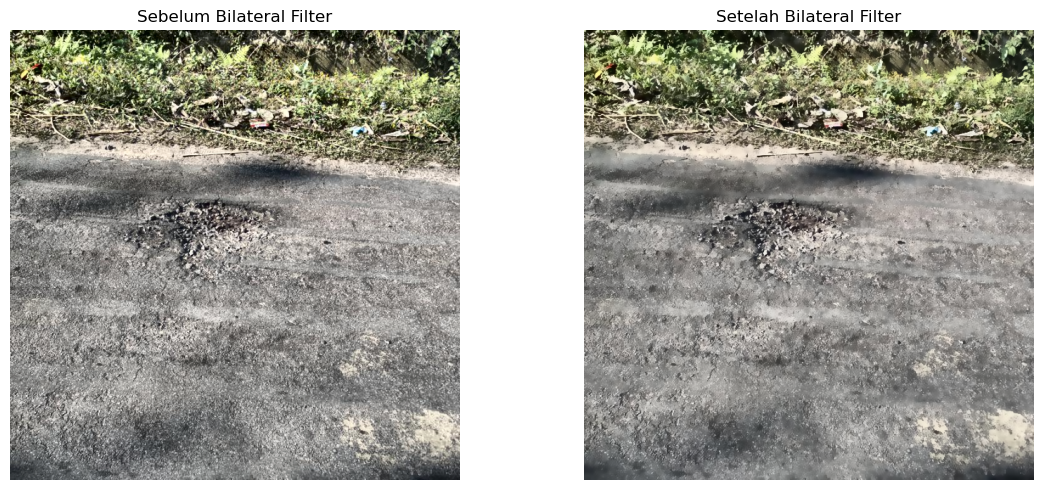

In [ ]:
def apply_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    """
    Menerapkan bilateral filter untuk noise reduction dengan edge preservation.
    
    Args:
        image: Input image
        d: Diameter pixel neighborhood
        sigma_color: Filter sigma dalam color space (larger value = more colors mixed)
        sigma_space: Filter sigma dalam coordinate space (larger value = farther pixels influence)
    
    Returns:
        filtered_image: Gambar hasil filtering
    """
    filtered = cv2.bilateralFilter(image, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)
    return filtered

# Test bilateral filter pada gambar hasil CLAHE
bilateral_img = apply_bilateral_filter(clahe_img)
bilateral_img_rgb = cv2.cvtColor(bilateral_img, cv2.COLOR_BGR2RGB)

# Visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(clahe_img_rgb)
axes[0].set_title("Sebelum Bilateral Filter")
axes[0].axis('off')

axes[1].imshow(bilateral_img_rgb)
axes[1].set_title("Setelah Bilateral Filter")
axes[1].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'preprocessing_3_bilateral.png'), dpi=100, bbox_inches='tight')
plt.show()

## 9. Preprocessing Seluruh Dataset

Menerapkan pipeline preprocessing pada seluruh dataset (train, valid, test) dan menyimpan hasilnya.

In [ ]:
def preprocess_image(image_path, target_size=640):
    # Load gambar
    image = cv2.imread(image_path)
    
    # Step 1: Resize dengan padding
    resized, scale, offsets = resize(image, target_size)
    
    # Step 2: CLAHE Enhancement
    enhanced = apply_clahe(resized)
    
    # Step 3: Bilateral Filter
    filtered = apply_bilateral_filter(enhanced)
    
    return filtered, scale, offsets

def adjust_yolo_labels(label_path, scale, offsets, target_size=640):
    if not os.path.exists(label_path):
        return []
    
    adjusted_labels = []
    x_offset, y_offset = offsets
    
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = parts[0]
                x_center = float(parts[1])
                y_center = float(parts[2])
                width = float(parts[3])
                height = float(parts[4])

                # Adjust dengan scale dan offset
                new_x = (x_center * scale + x_offset / target_size)
                new_y = (y_center * scale + y_offset / target_size)
                new_w = width * scale
                new_h = height * scale
                
                # Ensure coordinates are within [0, 1]
                new_x = max(0, min(1, new_x))
                new_y = max(0, min(1, new_y))
                new_w = max(0, min(1, new_w))
                new_h = max(0, min(1, new_h))
                
                adjusted_label = f"{class_id} {new_x:.6f} {new_y:.6f} {new_w:.6f} {new_h:.6f}"
                adjusted_labels.append(adjusted_label)
    
    return adjusted_labels

def preprocess_dataset_split(dataset_path, output_path, split='train', target_size=640):
    images_dir = os.path.join(dataset_path, split, 'images')
    labels_dir = os.path.join(dataset_path, split, 'labels')
    
    output_images_dir = os.path.join(output_path, split, 'images')
    output_labels_dir = os.path.join(output_path, split, 'labels')
    
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)
    
    # Get all images
    image_files = glob.glob(os.path.join(images_dir, '*.*'))
    
    print(f"\nMemproses {split} set: {len(image_files)} gambar")
    
    for img_path in tqdm(image_files, desc=f"Preprocessing {split}"):
        # Preprocess gambar
        preprocessed_img, scale, offsets = preprocess_image(img_path, target_size)
        
        # Simpan gambar hasil preprocessing
        filename = os.path.basename(img_path)
        output_img_path = os.path.join(output_images_dir, filename)
        cv2.imwrite(output_img_path, preprocessed_img)
        
        # Adjust dan simpan label
        label_filename = filename.replace('.jpg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(labels_dir, label_filename)

        
        if os.path.exists(label_path):
            output_label_path = os.path.join(output_labels_dir, label_filename)
            shutil.copy2(label_path, output_label_path)
    
    print(f"Selesai memproses {split} set")

# Preprocess seluruh dataset
print("Memulai preprocessing dataset...")

for split in ['train', 'valid', 'test']:
    split_path = os.path.join(ORIGINAL_DATASET, split)
    if os.path.exists(split_path):
        preprocess_dataset_split(ORIGINAL_DATASET, PREPROCESSED_DATASET, split)

print("\nPreprocessing dataset selesai!")
print(f"Dataset hasil preprocessing disimpan di: {PREPROCESSED_DATASET}")

Memulai preprocessing dataset...

Memproses train set: 465 gambar


Preprocessing train:   0%|          | 0/465 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 10. Konsep PCD 4: Data Augmentation

Data augmentation adalah teknik untuk memperbanyak dataset dengan membuat variasi dari gambar existing. Tujuannya:
- Meningkatkan jumlah data training
- Meningkatkan variasi data untuk generalisasi model yang lebih baik
- Mengurangi overfitting

Augmentasi yang diterapkan:

**Transformasi Geometrik:**
- Horizontal flip: Simulasi lubang dari sudut berbeda
- Rotation: Variasi orientasi
- Shift/Translate: Variasi posisi objek

**Transformasi Fotometrik:**
- Brightness adjustment: Simulasi kondisi pencahayaan berbeda
- Contrast adjustment: Variasi kondisi cuaca
- Blur: Simulasi kamera yang bergerak atau tidak fokus

In [ ]:
# Definisi augmentation pipeline menggunakan Albumentations
augmentation_pipeline = A.Compose([
    # Transformasi Geometrik
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5),
    
    # Transformasi Fotometrik
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.GaussNoise(var_limit=(10, 50), p=0.3),
    
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

Pipeline augmentation berhasil didefinisikan

Jenis augmentasi yang diterapkan:
1. Horizontal Flip (50% probability)
2. Rotation maksimal 15 derajat (50% probability)
3. Shift, Scale, Rotate kecil (50% probability)
4. Random Brightness dan Contrast (50% probability)
5. Gaussian Blur (30% probability)
6. Gaussian Noise (30% probability)


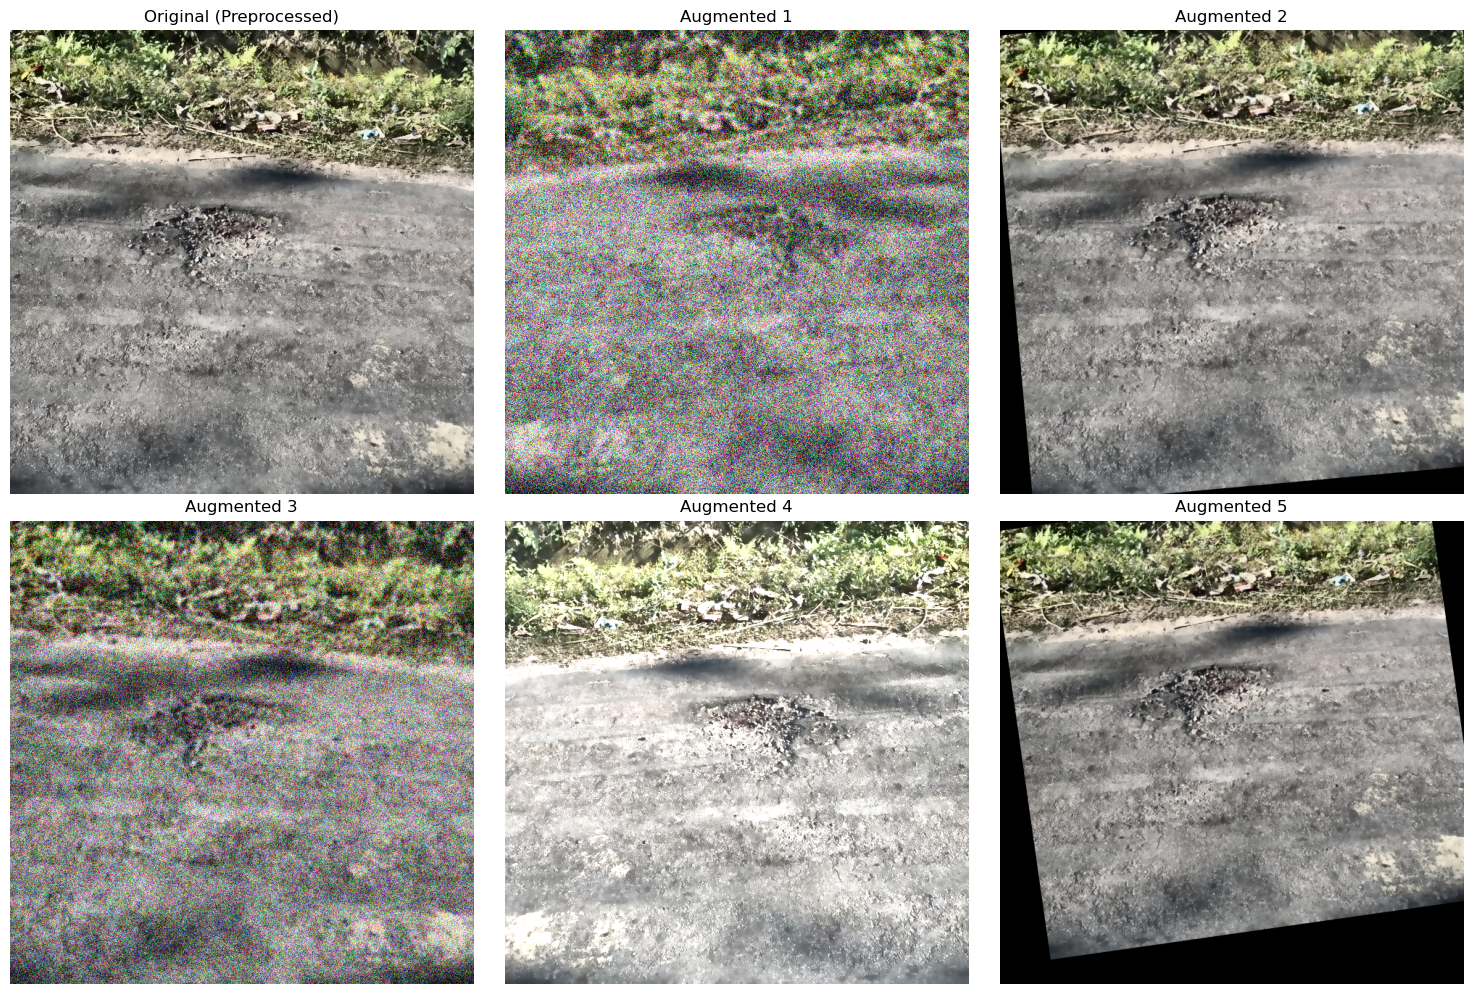

Contoh hasil augmentasi telah divisualisasi
Original bounding boxes: 1


In [ ]:
def augment_image_with_labels(image, bboxes, class_labels, transform):
    try:
        transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        return transformed['image'], transformed['bboxes'], transformed['class_labels']
    except Exception as e:
        print(f"Error dalam augmentasi: {e}")
        return image, bboxes, class_labels

def parse_yolo_label(label_path):
    bboxes = []
    class_labels = []
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) == 5:
                    class_labels.append(int(parts[0]))
                    bbox = [float(x) for x in parts[1:]]
                    bboxes.append(bbox)
    
    return bboxes, class_labels

def save_yolo_label(label_path, bboxes, class_labels):
    with open(label_path, 'w') as f:
        for bbox, cls in zip(bboxes, class_labels):
            line = f"{cls} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n"
            f.write(line)

# Test augmentation pada satu gambar
test_preprocessed_path = os.path.join(PREPROCESSED_DATASET, 'train', 'images', os.path.basename(train_images[0]))
test_label_path = test_preprocessed_path.replace('images', 'labels').replace('.jpg', '.txt').replace('.png', '.txt')

# Load gambar dan label
test_img = cv2.imread(test_preprocessed_path)
test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
bboxes, class_labels = parse_yolo_label(test_label_path)

# Generate beberapa augmented versions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# Original
axes[0].imshow(test_img_rgb)
axes[0].set_title("Original (Preprocessed)")
axes[0].axis('off')

# Generate 5 augmented versions
for i in range(1, 6):
    aug_img, aug_bboxes, aug_labels = augment_image_with_labels(
        test_img_rgb, bboxes, class_labels, augmentation_pipeline
    )
    
    axes[i].imshow(aug_img)
    axes[i].set_title(f"Augmented {i}")
    axes[i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'augmentation_examples.png'), dpi=100, bbox_inches='tight')
plt.show()

## 11. Augmentasi Seluruh Training Dataset

Menerapkan augmentasi pada seluruh training set untuk memperbanyak data. Setiap gambar akan di-augmentasi beberapa kali dengan variasi random.

In [ ]:
def augment_dataset(input_path, output_path, split='train', num_augmentations=3):
    images_dir = os.path.join(input_path, split, 'images')
    labels_dir = os.path.join(input_path, split, 'labels')
    
    output_images_dir = os.path.join(output_path, split, 'images')
    output_labels_dir = os.path.join(output_path, split, 'labels')
    
    os.makedirs(output_images_dir, exist_ok=True)
    os.makedirs(output_labels_dir, exist_ok=True)
    
    # Copy original images first
    image_files = glob.glob(os.path.join(images_dir, '*.*'))
    
    print(f"\nMemulai augmentasi {split} set")
    print(f"Jumlah gambar original: {len(image_files)}")
    print(f"Augmentasi per gambar: {num_augmentations}")
    print(f"Total gambar setelah augmentasi: {len(image_files) * (num_augmentations + 1)}")
    
    for img_path in tqdm(image_files, desc=f"Augmenting {split}"):
        filename = os.path.basename(img_path)
        basename = os.path.splitext(filename)[0]
        ext = os.path.splitext(filename)[1]
        
        # Load gambar dan label
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label_path = os.path.join(labels_dir, basename + '.txt')
        bboxes, class_labels = parse_yolo_label(label_path)
        
        # Simpan gambar original
        shutil.copy2(img_path, os.path.join(output_images_dir, filename))
        if os.path.exists(label_path):
            shutil.copy2(label_path, os.path.join(output_labels_dir, basename + '.txt'))
        
        # Generate augmented versions
        for aug_idx in range(num_augmentations):
            aug_img, aug_bboxes, aug_labels = augment_image_with_labels(
                image_rgb, bboxes, class_labels, augmentation_pipeline
            )
            
            # Convert back to BGR for saving
            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
            
            # Save augmented image
            aug_filename = f"{basename}_aug{aug_idx+1}{ext}"
            aug_img_path = os.path.join(output_images_dir, aug_filename)
            cv2.imwrite(aug_img_path, aug_img_bgr)
            
            # Save augmented label
            aug_label_path = os.path.join(output_labels_dir, f"{basename}_aug{aug_idx+1}.txt")
            if len(aug_bboxes) > 0:
                save_yolo_label(aug_label_path, aug_bboxes, aug_labels)
    
    print(f"Selesai augmentasi {split} set")

# Augmentasi training set saja (valid dan test tidak perlu di-augmentasi)
print("Memulai proses augmentasi...")
augment_dataset(PREPROCESSED_DATASET, AUGMENTED_DATASET, split='train', num_augmentations=3)

# Copy valid dan test set tanpa augmentasi
for split in ['valid', 'test']:
    split_path = os.path.join(PREPROCESSED_DATASET, split)
    if os.path.exists(split_path):
        output_split_path = os.path.join(AUGMENTED_DATASET, split)
        if os.path.exists(output_split_path):
            shutil.rmtree(output_split_path)
        shutil.copytree(split_path, output_split_path)


Memulai proses augmentasi...

Memulai augmentasi train set
Jumlah gambar original: 465
Augmentasi per gambar: 3
Total gambar setelah augmentasi: 1860


Augmenting train: 100%|██████████| 465/465 [01:26<00:00,  5.36it/s]


Selesai augmentasi train set

Valid set telah di-copy (tanpa augmentasi)

Test set telah di-copy (tanpa augmentasi)

Proses augmentasi selesai!
Dataset augmented tersimpan di: pothole_augmented


## 13. Pembuatan File Konfigurasi YOLO

Membuat file data.yaml yang dibutuhkan untuk training YOLO.

In [ ]:
# Buat file data.yaml untuk YOLO
data_yaml = {
    'path': os.path.abspath(AUGMENTED_DATASET),
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': 1,
    'names': ['pothole']
}

yaml_path = os.path.join(AUGMENTED_DATASET, 'data.yaml')
with open(yaml_path, 'w') as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("File konfigurasi YOLO telah dibuat:")
print(f"Path: {yaml_path}")
print("\nIsi file:")
with open(yaml_path, 'r') as f:
    print(f.read())

File konfigurasi YOLO telah dibuat:
Path: pothole_augmented\data.yaml

Isi file:
path: d:\kuliah\smt 7\PCD\Pothole_Detection\pothole_augmented
train: train/images
val: valid/images
test: test/images
nc: 1
names:
- pothole



## 14. Training Model YOLO

Melakukan training model YOLOv8 dengan dataset yang telah dipreprocessing dan diaugmentasi.

In [ ]:
# Load pretrained YOLO model
model = YOLO('yolov8n.pt')  # nano model untuk training lebih cepat
# Atau gunakan 'yolov8s.pt', 'yolov8m.pt' untuk model yang lebih besar

print("Model YOLOv8 berhasil di-load")
print("Memulai training...")
print("\nParameter training:")
print("- Epochs: 100")
print("- Image size: 640")
print("- Batch size: 16")
print("- Patience: 20 (early stopping)")

Model YOLOv8 berhasil di-load
Memulai training...

Parameter training:
- Epochs: 100
- Image size: 640
- Batch size: 16
- Patience: 20 (early stopping)


In [ ]:
# Training
results = model.train(
    data=yaml_path,
    epochs=100,
    imgsz=640,
    batch=16,
    patience=20,
    save=True,
    project=OUTPUT_DIR,
    name='pothole_detection',
    exist_ok=True,
    pretrained=True,
    optimizer='Adam',
    verbose=True,
    seed=42,
    deterministic=True,
    val=True
)

print("\nTraining selesai!")
print(f"Model terbaik tersimpan di: {OUTPUT_DIR}/pothole_detection/weights/ashpalt.pt")

New https://pypi.org/project/ultralytics/8.3.230 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.228  Python-3.10.18 torch-2.9.1+cpu CPU (AMD Athlon Gold 3150U with Radeon Graphics)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pothole_augmented\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=pothole_detection, nb

## 15. Evaluasi Model

Mengevaluasi performa model pada validation dan test set.

In [ ]:
# Load best model
best_model_path = os.path.join(OUTPUT_DIR, 'pothole_detection', 'weights', 'ashpalt.pt')
best_model = YOLO(best_model_path)

# Validasi
print("Evaluasi pada validation set...")
val_results = best_model.val(data=yaml_path, split='val')

print("\nHasil Validasi:")
print(f"mAP50: {val_results.box.map50:.4f}")
print(f"mAP50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")

# Test
print("\nEvaluasi pada test set...")
test_results = best_model.val(data=yaml_path, split='test')

print("\nHasil Test:")
print(f"mAP50: {test_results.box.map50:.4f}")
print(f"mAP50-95: {test_results.box.map:.4f}")
print(f"Precision: {test_results.box.mp:.4f}")
print(f"Recall: {test_results.box.mr:.4f}")

## 16. Visualisasi Hasil Prediksi

Menampilkan hasil prediksi model pada beberapa gambar test.

In [ ]:
# Ambil beberapa gambar test untuk prediksi
test_images = glob.glob(os.path.join(AUGMENTED_DATASET, 'test', 'images', '*.*'))[:6]

# Prediksi
predictions = best_model.predict(test_images, conf=0.25, iou=0.45, save=False)

# Visualisasi
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, (img_path, pred) in enumerate(zip(test_images, predictions)):
    # Load gambar
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Gambar bounding boxes
    if len(pred.boxes) > 0:
        for box in pred.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(img_rgb, f'Pothole {conf:.2f}', (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(f"Prediksi {idx+1}")
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'prediction_samples.png'), dpi=100, bbox_inches='tight')
plt.show()

print("Visualisasi hasil prediksi telah disimpan")

## 17. Analisis Hasil Training

Menampilkan grafik training metrics dari hasil training.

In [ ]:
# Load dan tampilkan training curves
results_dir = os.path.join(OUTPUT_DIR, 'pothole_detection')

# Training curves biasanya disimpan oleh YOLO sebagai gambar
curve_files = [
    'results.png',
    'confusion_matrix.png',
    'PR_curve.png',
    'F1_curve.png'
]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, curve_file in enumerate(curve_files):
    curve_path = os.path.join(results_dir, curve_file)
    if os.path.exists(curve_path):
        img = plt.imread(curve_path)
        axes[idx].imshow(img)
        axes[idx].set_title(curve_file.replace('.png', '').replace('_', ' ').title())
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f"{curve_file} tidak tersedia", 
                      ha='center', va='center')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_analysis.png'), dpi=100, bbox_inches='tight')
plt.show()

print("Analisis hasil training telah divisualisasi")